In [1]:
#import libraries 
import pandas as pd 
import os
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from wordcloud import STOPWORDS
from collections import defaultdict
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
import joblib 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 

## Sentiment Analysis Using Pre-trained Model

We performed sentiment analysis on our data using a pre-trained model to determine the sentiment of the text in each record. Here's how it was done:

1. **Model Selection**: We utilized a pre-trained sentiment analysis model called `finiteautomata/bertweet-base-sentiment-analysis`.

2. **Function for Sentiment Labeling**: We created a function that takes a text as input and utilizes the selected model to predict the sentiment label of the text.

    ```python
    from transformers import pipeline
    sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

    def get_sentiment_label(text):
        try:
            return sentiment_analysis(text)[0]['label']
        except Exception as e:
            print(f"Error processing text.")
            return None  # or return a default label or handle the error as needed
    ```

3. **Application to Our Data**: We applied this function to each text record in our dataset, which allowed us to predict the sentiment label for each text.

    ```python
    df['sentiment'] = df['full_text'].apply(get_sentiment_label)
    ```

4. **Sentiment Labeling**: As a result, our data now contains an additional 'sentiment' column, which holds the predicted sentiment labels for each text record.

   - Example Sentiment Labels:
     - 'POS' (Positive)
     - 'NEU' (Neutral)
     - 'NEG' (Negative)

This process enabled us to analyze the sentiment of the text in our data and gain insights into the overall sentiment trends.


In [2]:
#import our dfs
fb_df = pd.read_csv('processed_fb_posts.csv')
tweet_df = pd.read_csv('processed_tweets.csv')


#drop unnecessary columns
fb_df= fb_df[['url','text','sentiment']]
tweet_df =tweet_df[['full_text','url','sentiment']]

#rename columns
fb_df.rename(columns={'text':'full_text'},inplace=True)

#merge dfs
df = pd.merge(fb_df,tweet_df,how='outer')

In [3]:
df.head()

,url,full_text,sentiment
0,https://www.facebook.com/christopher.kiptoo.5/...,Matters climate change mitigation and adaptati...,NEU
1,https://www.facebook.com/christopher.kiptoo.5/...,We The National Treasury led by Cabinet Secret...,NaN
2,https://www.facebook.com/christopher.kiptoo.5/...,Congratulations. Let us keep greening Kenya in...,POS
3,https://www.facebook.com/christopher.kiptoo.5/...,While here in Rome Italy attending the United ...,NEU
4,https://www.facebook.com/christopher.kiptoo.5/...,In Rome Italy this week accompanying Deputy Pr...,NaN


In [4]:
# Calculate the mode of the 'sentiment' column
mode_sentiment = df['sentiment'].mode()[0]

# Fill NaN values with the mode
df['sentiment'].fillna(mode_sentiment, inplace=True)


In [5]:
df.to_csv('merged_df.csv',index=False)

In [8]:
#number of samples
num_samples = len(df)

# Handle missing values (NaN) in the 'full_text' column by filling them with empty strings
df['full_text'].fillna('', inplace=True)

# Calculate average sentence length
df['sentence_length'] = df['full_text'].apply(lambda x: len(x.split()))
average_sentence_length = df['sentence_length'].mean()


In [9]:
average_sentence_length

30.073506788843556

Text(0, 0.5, 'Frequency')

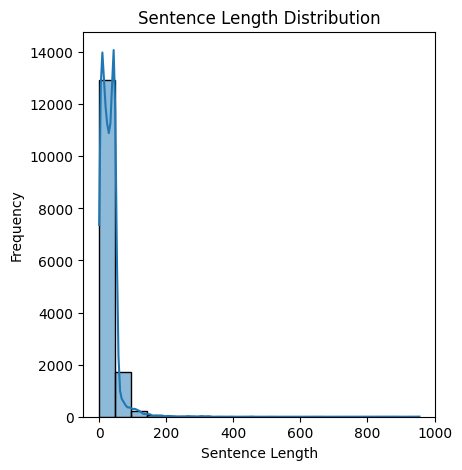

In [10]:
# Visualize data distribution using histograms or other plots
plt.figure(figsize=(10, 5))

# Plot a histogram of sentence lengths
plt.subplot(1, 2, 1)
sns.histplot(df['sentence_length'], bins=20, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')


In [13]:
df.sample(5)

,url,full_text,sentiment,sentence_length
4301,https://twitter.com/JimiWanjigi/status/1554944...,Congratulations! @Ferdiomanyala You have done ...,POS,10
9366,NaN,I want but i can't act for President Elect Rut...,NEG,45
12927,NaN,"5/08/22!\nSomebody say\n""Happy Birthday to the...",POS,9
3621,https://twitter.com/MillicentOmanga/status/151...,"I want to thank DP @WilliamsRuto, our party @U...",POS,48
6766,https://twitter.com/KBonimtetezi/status/161903...,"Mr. @skmusyoka, we are keenly following https:...",NEU,7


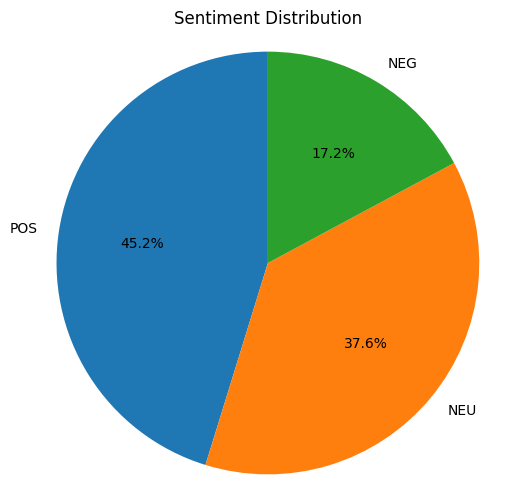

In [14]:
# Count the number of tweets by sentiments
sentiment_counts = df['sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6), dpi=100)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Sentiment Distribution")

plt.show()


In [15]:
#cleaning our data
def remove_pattern(text, pattern):
    if isinstance(text, str):
        return re.sub(pattern, '', text)
    else:
        return text

In [16]:
df['tidy_text'] = np.vectorize(remove_pattern)(df['full_text'], "@[\w]*")

df.head()

,url,full_text,sentiment,sentence_length,tidy_text
0,https://www.facebook.com/christopher.kiptoo.5/...,Matters climate change mitigation and adaptati...,NEU,8,Matters climate change mitigation and adaptati...
1,https://www.facebook.com/christopher.kiptoo.5/...,We The National Treasury led by Cabinet Secret...,POS,122,We The National Treasury led by Cabinet Secret...
2,https://www.facebook.com/christopher.kiptoo.5/...,Congratulations. Let us keep greening Kenya in...,POS,16,Congratulations. Let us keep greening Kenya in...
3,https://www.facebook.com/christopher.kiptoo.5/...,While here in Rome Italy attending the United ...,NEU,89,While here in Rome Italy attending the United ...
4,https://www.facebook.com/christopher.kiptoo.5/...,In Rome Italy this week accompanying Deputy Pr...,POS,114,In Rome Italy this week accompanying Deputy Pr...


In [17]:
#removing special characters, numbers, punctuations
df['tidy_text'] = df['tidy_text'].str.replace("[^a-zA-Z#]", " ")

df.head()

,url,full_text,sentiment,sentence_length,tidy_text
0,https://www.facebook.com/christopher.kiptoo.5/...,Matters climate change mitigation and adaptati...,NEU,8,Matters climate change mitigation and adaptati...
1,https://www.facebook.com/christopher.kiptoo.5/...,We The National Treasury led by Cabinet Secret...,POS,122,We The National Treasury led by Cabinet Secret...
2,https://www.facebook.com/christopher.kiptoo.5/...,Congratulations. Let us keep greening Kenya in...,POS,16,Congratulations. Let us keep greening Kenya in...
3,https://www.facebook.com/christopher.kiptoo.5/...,While here in Rome Italy attending the United ...,NEU,89,While here in Rome Italy attending the United ...
4,https://www.facebook.com/christopher.kiptoo.5/...,In Rome Italy this week accompanying Deputy Pr...,POS,114,In Rome Italy this week accompanying Deputy Pr...


In [18]:
#removing short words
df['tidy_text'] = df['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

df.head()

,url,full_text,sentiment,sentence_length,tidy_text
0,https://www.facebook.com/christopher.kiptoo.5/...,Matters climate change mitigation and adaptati...,NEU,8,Matters climate change mitigation adaptation K...
1,https://www.facebook.com/christopher.kiptoo.5/...,We The National Treasury led by Cabinet Secret...,POS,122,National Treasury Cabinet Secretary Prof. Njug...
2,https://www.facebook.com/christopher.kiptoo.5/...,Congratulations. Let us keep greening Kenya in...,POS,16,Congratulations. keep greening Kenya order mit...
3,https://www.facebook.com/christopher.kiptoo.5/...,While here in Rome Italy attending the United ...,NEU,89,While here Rome Italy attending United Nations...
4,https://www.facebook.com/christopher.kiptoo.5/...,In Rome Italy this week accompanying Deputy Pr...,POS,114,Rome Italy this week accompanying Deputy Presi...


In [19]:
#tokenization
tokenized_tweet = df['tidy_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Matters, climate, change, mitigation, adaptat...
1    [National, Treasury, Cabinet, Secretary, Prof....
2    [Congratulations., keep, greening, Kenya, orde...
3    [While, here, Rome, Italy, attending, United, ...
4    [Rome, Italy, this, week, accompanying, Deputy...
Name: tidy_text, dtype: object

In [20]:
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0      [matter, climat, chang, mitig, adapt, kaptagat]
1    [nation, treasuri, cabinet, secretari, prof., ...
2    [congratulations., keep, green, kenya, order, ...
3    [while, here, rome, itali, attend, unit, natio...
4    [rome, itali, thi, week, accompani, deputi, pr...
Name: tidy_text, dtype: object

In [21]:
#stitching tokens back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['tidy_text'] = tokenized_tweet
df.head()

,url,full_text,sentiment,sentence_length,tidy_text
0,https://www.facebook.com/christopher.kiptoo.5/...,Matters climate change mitigation and adaptati...,NEU,8,matter climat chang mitig adapt kaptagat
1,https://www.facebook.com/christopher.kiptoo.5/...,We The National Treasury led by Cabinet Secret...,POS,122,nation treasuri cabinet secretari prof. njugun...
2,https://www.facebook.com/christopher.kiptoo.5/...,Congratulations. Let us keep greening Kenya in...,POS,16,congratulations. keep green kenya order mitig ...
3,https://www.facebook.com/christopher.kiptoo.5/...,While here in Rome Italy attending the United ...,NEU,89,while here rome itali attend unit nation food ...
4,https://www.facebook.com/christopher.kiptoo.5/...,In Rome Italy this week accompanying Deputy Pr...,POS,114,rome itali thi week accompani deputi presid h....


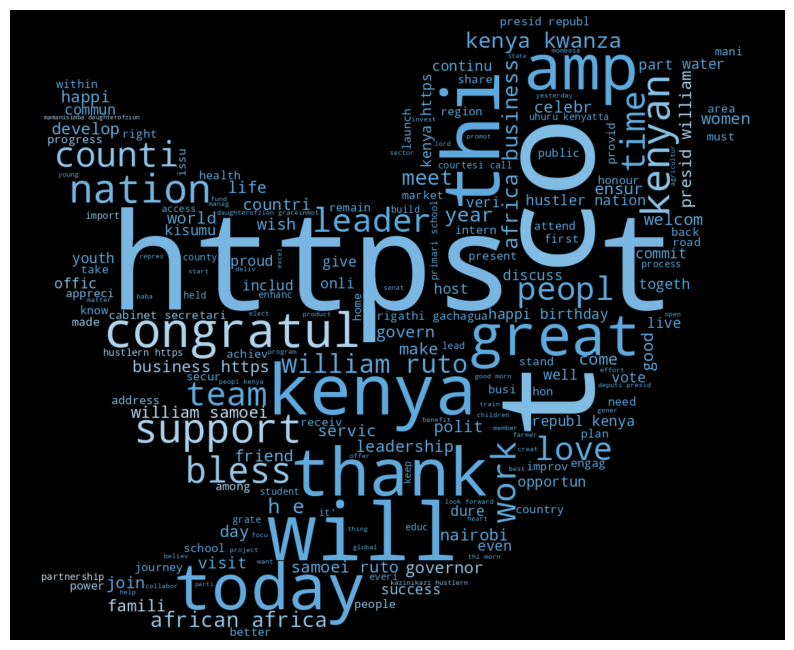

In [22]:
#wordcloud 
#store all the words from the tweets that are positive
all_words_positive= ' '.join([text for text in df['tidy_text'][df['sentiment'] == 'POS']])


# combining the image with the dataset
Mask = np.array(
    Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', 
                         stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

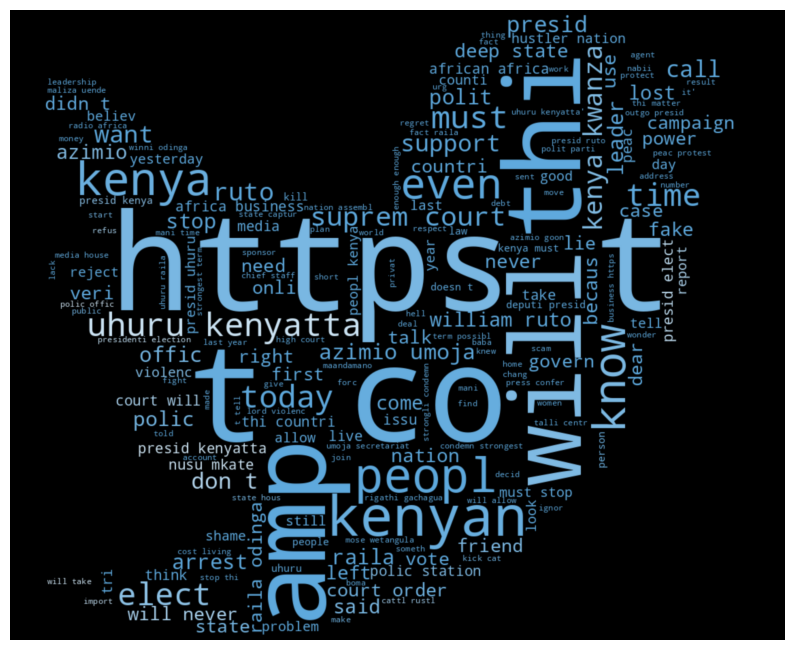

In [23]:
#store all the words from the tweets that are negative
all_words_negative= ' '.join([text for text in df['tidy_text'][df['sentiment'] == 'NEG']])

# combining the image with the dataset
Mask = np.array(
    Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', 
                            stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_negative)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")

plt.axis('off')
plt.show()

In [24]:
#function to extract hashtags
def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

In [25]:
ht_positive = Hashtags_Extract(df['tidy_text'][df['sentiment'] == 'POS'])
ht_negative = Hashtags_Extract(df['tidy_text'][df['sentiment'] == 'NEG'])


#unnesting list
ht_positive_unnest = sum(ht_positive,[])
ht_negative_unnest = sum(ht_negative,[])


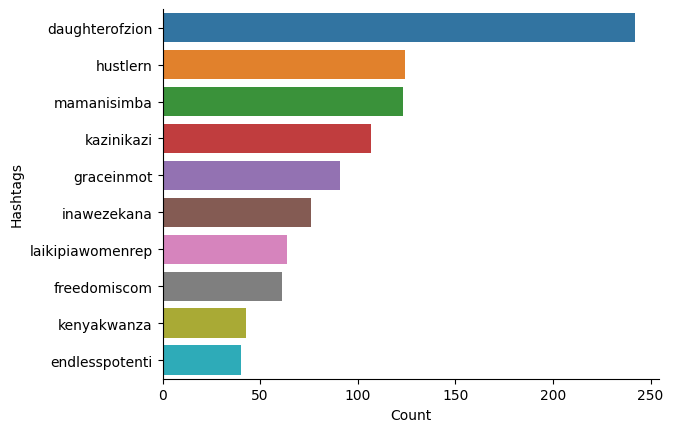

In [26]:
#counting the frequency of words having positive sentiment
word_freq_positive = nltk.FreqDist(ht_positive_unnest)
#creating a dataframe for the most frequently used words in hashtags
df_positive = pd.DataFrame({'Hashtags':list(word_freq_positive.keys()),'Count':list(word_freq_positive.values())})


#plotting the barplot for the most frequently used words in hashtags
df_positive_plot = df_positive.nlargest(10,columns='Count')
sns.barplot(data=df_positive_plot,y='Hashtags',x='Count')
sns.despine()

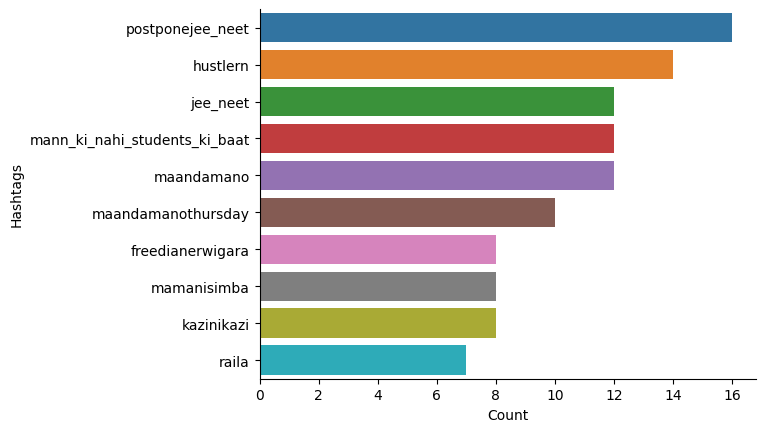

In [27]:
# counting the frequency of words having negative sentiment
word_freq_negative = nltk.FreqDist(ht_negative_unnest)
df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})


#plotting the barplot for the most frequently used words in hashtags
df_negative_plot = df_negative.nlargest(10,columns='Count')
sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()

In [28]:
# Define a mapping dictionary
sentiment_mapping = {'POS': 0, 'NEG': 1, 'NEU': 2}

# Map the 'sentiment' column to numerical labels
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)


In [29]:
df.head()

,url,full_text,sentiment,sentence_length,tidy_text,sentiment_label
0,https://www.facebook.com/christopher.kiptoo.5/...,Matters climate change mitigation and adaptati...,NEU,8,matter climat chang mitig adapt kaptagat,2
1,https://www.facebook.com/christopher.kiptoo.5/...,We The National Treasury led by Cabinet Secret...,POS,122,nation treasuri cabinet secretari prof. njugun...,0
2,https://www.facebook.com/christopher.kiptoo.5/...,Congratulations. Let us keep greening Kenya in...,POS,16,congratulations. keep green kenya order mitig ...,0
3,https://www.facebook.com/christopher.kiptoo.5/...,While here in Rome Italy attending the United ...,NEU,89,while here rome itali attend unit nation food ...,2
4,https://www.facebook.com/christopher.kiptoo.5/...,In Rome Italy this week accompanying Deputy Pr...,POS,114,rome itali thi week accompani deputi presid h....,0


In [30]:
#Modelling
bow_vectorizer = CountVectorizer(max_df=0.9, min_df=1, max_features=1000, stop_words='english')



# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['tidy_text'])
df_bow = pd.DataFrame(bow.todense())

#save vectorizer
joblib.dump(bow_vectorizer, 'bow_vectorizer.joblib')

['bow_vectorizer.joblib']

In [31]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=1, max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['tidy_text'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense())


In [32]:
train_bow = bow[:12000]
train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [33]:
train_tfidf_matrix = tfidf_matrix[:12000]
train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [34]:

x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(
    train_bow, 
    df['sentiment_label'][:12000], 
    test_size=0.3, 
    random_state=2)



In [35]:
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(
    train_tfidf_matrix, 
    df['sentiment_label'][:12000], 
    test_size=0.3, 
    random_state=17)

In [36]:
y_train_bow.fillna(0, inplace=True)
y_valid_bow.fillna(0, inplace=True)

In [37]:

from  sklearn.naive_bayes import ComplementNB,BernoulliNB

model_dir ="saved_models/"

# Create dictionaries to store F1-Scores and Accuracy for each classifier
bow_f1_score = {}
bow_accuracy_score = {}
saved_models ={}

# Create a dictionary of classifiers
classifiers = {
    'Mulitinomial Naive Bayes': MultinomialNB(),
    'SVM': SVC(probability=True),  # Set probability=True for SVC
}


# Iterate through each classifier
for classifier_name, classifier in classifiers.items():
    # Fit the model on the training data
    classifier.fit(x_train_bow, y_train_bow)

    # Predict on the validation set
    if 'SVM' in classifier_name:
        prediction = classifier.predict(x_valid_bow)  # Use predict for SVM
    else:
        prediction = classifier.predict(x_valid_bow)

    # Calculate the F1-Score and Accuracy for each class
    f1 = np.round(f1_score(y_valid_bow, prediction, average=None), 2)
    accuracy = np.round(accuracy_score(y_valid_bow, prediction), 2)

    # Store the F1-Score and Accuracy in the dictionaries
    bow_f1_score[classifier_name] = f1
    bow_accuracy_score[classifier_name] = accuracy

    # Print the F1-Score and Accuracy for each class
    print(f"{classifier_name}:")
    for class_idx, f1_score_class in enumerate(f1):
        print(f"Class {class_idx}: F1-Score: {f1_score_class}")
    print(f"Accuracy: {accuracy}")
    print()

    # Save the model
    model_filename =f"{model_dir}{classifier_name}_bow_model.joblib"
    joblib.dump(classifier, model_filename)

    # Save the model in the dictionary
    saved_models[classifier_name] = model_filename
    print(f"{classifier_name} model saved to {model_filename}")


# Print the dictionaries containing F1-Scores and Accuracy
print("F1-Scores for BoW:")
print(bow_f1_score)
print("Accuracy Scores for BoW:")
print(bow_accuracy_score)


Mulitinomial Naive Bayes:
Class 0: F1-Score: 0.79
Class 1: F1-Score: 0.6
Class 2: F1-Score: 0.67
Accuracy: 0.71

Mulitinomial Naive Bayes model saved to saved_models/Mulitinomial Naive Bayes_bow_model.joblib


SVM:
Class 0: F1-Score: 0.82
Class 1: F1-Score: 0.67
Class 2: F1-Score: 0.76
Accuracy: 0.77

SVM model saved to saved_models/SVM_bow_model.joblib
F1-Scores for BoW:
{'Mulitinomial Naive Bayes': array([0.79, 0.6 , 0.67]), 'SVM': array([0.82, 0.67, 0.76])}
Accuracy Scores for BoW:
{'Mulitinomial Naive Bayes': 0.71, 'SVM': 0.77}


In [38]:
y_train_tfidf.fillna(0, inplace=True)
y_valid_tfidf.fillna(0, inplace=True)

In [39]:

model_dir ="saved_models/"
# Create dictionaries to store F1-Scores and Accuracy for each classifier
tfidf_f1_score = {}
tfidf_accuracy_score = {}
saved_models={}

# Create a dictionary of classifiers
classifiers = {
    'SVM': SVC(probability=True),  # Set probability=True for SVC
    'Multinomial Naive Bayes': MultinomialNB(),
}
# Iterate through each classifier
for classifier_name, classifier in classifiers.items():
    # Fit the model on the training data
    classifier.fit(x_train_bow, y_train_bow)

    # Predict on the validation set
    if 'SVM' in classifier_name:
        prediction = classifier.predict(x_valid_tfidf)  # Use predict for SVM
    else:
        prediction = classifier.predict(x_valid_tfidf)

    # Calculate the F1-Score and Accuracy for each class
    f1 = np.round(f1_score(y_valid_tfidf, prediction, average=None), 2)
    accuracy = np.round(accuracy_score(y_valid_tfidf, prediction), 2)

    # Store the F1-Score and Accuracy in the dictionaries
    tfidf_f1_score[classifier_name] = f1
    tfidf_accuracy_score[classifier_name] = accuracy

    # Print the F1-Score and Accuracy for each class
    print(f"{classifier_name}:")
    for class_idx, f1_score_class in enumerate(f1):
        print(f"Class {class_idx}: F1-Score: {f1_score_class}")
    print(f"Accuracy: {accuracy}")
    print()

    # Save the model
    model_filename =f"{model_dir}{classifier_name}_tfidf_model.joblib"
    joblib.dump(classifier, model_filename)

    # Save the model in the dictionary
    saved_models[classifier_name] = model_filename
    print(f"{classifier_name} model saved to {model_filename}")


# Print the dictionaries containing F1-Scores and Accuracy
print("F1-Scores for TF-IDF:")
print(tfidf_f1_score)
print("Accuracy Scores for TF-IDF:")
print(tfidf_accuracy_score)


SVM:
Class 0: F1-Score: 0.47
Class 1: F1-Score: 0.15
Class 2: F1-Score: 0.63
Accuracy: 0.54

SVM model saved to saved_models/SVM_tfidf_model.joblib
Multinomial Naive Bayes:
Class 0: F1-Score: 0.79
Class 1: F1-Score: 0.62
Class 2: F1-Score: 0.69
Accuracy: 0.73

Multinomial Naive Bayes model saved to saved_models/Multinomial Naive Bayes_tfidf_model.joblib
F1-Scores for TF-IDF:
{'SVM': array([0.47, 0.15, 0.63]), 'Multinomial Naive Bayes': array([0.79, 0.62, 0.69])}
Accuracy Scores for TF-IDF:
{'SVM': 0.54, 'Multinomial Naive Bayes': 0.73}


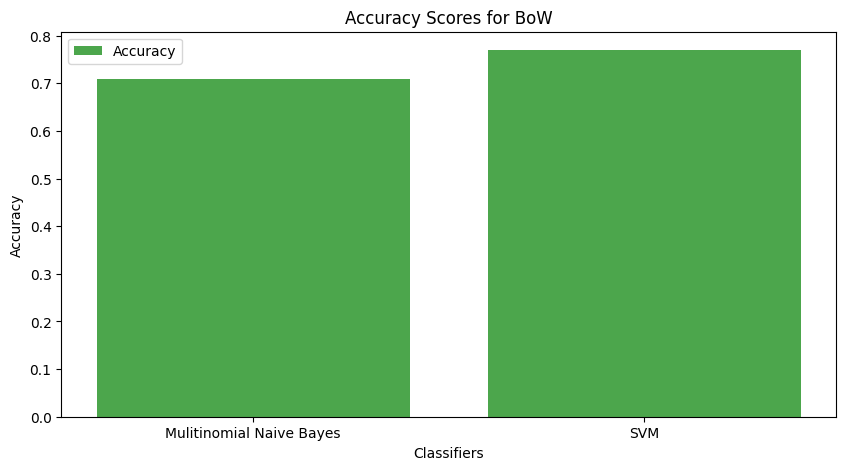

In [40]:
classifiers = list(bow_f1_score.keys())
f1_scores = [bow_f1_score[classifier] for classifier in classifiers]
accuracy_scores = [bow_accuracy_score[classifier] for classifier in classifiers]


# Plot Accuracy Scores
plt.figure(figsize=(10, 5))
plt.bar(classifiers, accuracy_scores, color='g', alpha=0.7, label='Accuracy')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for BoW')
plt.legend()

# Show the plot
plt.show()

In [41]:
# Create a DataFrame from the dictionaries
bow_df = pd.DataFrame({'Accuracy': bow_accuracy_score})

# Reset the index to have classifiers as a column
bow_df.reset_index(inplace=True)


In [42]:
bow_df.head()

,index,Accuracy
0,Mulitinomial Naive Bayes,0.71
1,SVM,0.77


In [43]:
bow_df.to_csv('bow_accuracy_df.csv', index=False)

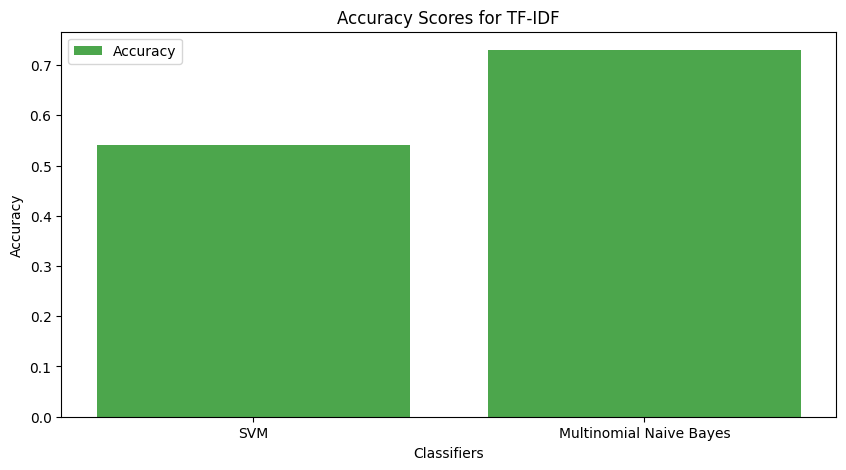

In [44]:
import matplotlib.pyplot as plt

# Data
classifiers = list(tfidf_f1_score.keys())
f1_scores = [tfidf_f1_score[classifier] for classifier in classifiers]
accuracy_scores = [tfidf_accuracy_score[classifier] for classifier in classifiers]


# Plot Accuracy Scores
plt.figure(figsize=(10, 5))
plt.bar(classifiers, accuracy_scores, color='g', alpha=0.7, label='Accuracy')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for TF-IDF')
plt.legend()

# Show the plot
plt.show()

In [45]:
# Create a DataFrame from the dictionaries
tfidf_df = pd.DataFrame({'Accuracy': tfidf_accuracy_score})

# Reset the index to have classifiers as a column
tfidf_df.reset_index(inplace=True)

tfidf_df.head()


,index,Accuracy
0,Multinomial Naive Bayes,0.73
1,SVM,0.54


In [46]:
bow_f1_score

{'Mulitinomial Naive Bayes': array([0.79, 0.6 , 0.67]),
 'SVM': array([0.82, 0.67, 0.76])}

In [47]:
bow_f1_score_df = pd.DataFrame(bow_f1_score)

In [48]:
bow_f1_score_df = bow_f1_score_df.T  # Transpose the DataFrame
bow_f1_score_df.reset_index(inplace=True)  # Reset the index

In [49]:

bow_f1_score_df.rename(columns={'index':'Models',0:'Negative',1:'Neutral',2:'Positive'},inplace=True)  # Rename the columns

bow_f1_score_df.to_csv('bow_f1_score_df.csv',index=False)

In [50]:
tfidf_f1_score_df = pd.DataFrame(tfidf_f1_score)
tfidf_f1_score_df = tfidf_f1_score_df.T
tfidf_f1_score_df.reset_index(inplace=True)
tfidf_f1_score_df.rename(columns={'index':'Models',0:'Negative',1:'Neutral',2:'Positive'},inplace=True)
tfidf_f1_score_df.to_csv('tfidf_f1_score_df.csv',index=False)

In [51]:
tfidf_df.to_csv('tfidf_accuracy_df.csv', index=False)

In [52]:
model = MultinomialNB()
model.fit(x_train_bow, y_train_bow)
prediction = model.predict(x_valid_bow)
print("F1-Score:", f1_score(y_valid_bow, prediction, average=None))
print("Accuracy-score", accuracy_score(y_valid_bow, prediction))

F1-Score: [0.79137116 0.59545837 0.66615912]
Accuracy-score 0.7133333333333334


In [53]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [54]:
from sklearn.model_selection import train_test_split,GridSearchCV
params_NB = {
    'alpha': np.logspace(0, -9, num=100),
    'fit_prior': [True, False],  # Add more parameters here
}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')


In [55]:


gs_NB.fit(x_train_bow, y_train_bow);

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


In [56]:
gs_NB.best_params_

{'alpha': 5.3366992312063123e-05, 'fit_prior': True}

In [57]:
gs_NB.best_score_

0.7221031746031746

In [58]:
params = {'alpha': 5.3366992312063123e-05, 'fit_prior': True}
nb_bow = MultinomialNB(**params)
nb_bow.fit(x_train_bow, y_train_bow)
prediction = nb_bow.predict(x_valid_bow)
print("F1-Score:", f1_score(y_valid_bow, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_bow, prediction),2))

F1-Score: [0.7956611  0.59655172 0.67554203]
Accuracy-score 0.72


In [59]:
nb_tfidf = MultinomialNB(**params)
nb_tfidf.fit(x_train_tfidf, y_train_tfidf)
prediction = nb_tfidf.predict(x_valid_tfidf)
print("F1-Score:", f1_score(y_valid_tfidf, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_tfidf, prediction),2))


F1-Score: [0.78748591 0.62340216 0.6914611 ]
Accuracy-score 0.73


In [60]:
#SVM Hyperparemeter tuning 
#Hyperparamter tuning using Gridsearch
params={'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
svc_bow = SVC(**params)

svc_bow.fit(x_train_bow, y_train_bow)
prediction = svc_bow.predict(x_valid_bow)
print("F1-Score:", f1_score(y_valid_bow, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_bow, prediction),2))



F1-Score: [0.80179028 0.61693548 0.73701299]
Accuracy-score 0.75


In [61]:
svc_tf = SVC(**params)
svc_tf.fit(x_train_tfidf, y_train_tfidf)
prediction = svc_tf.predict(x_valid_tfidf)
print("F1-Score:", f1_score(y_valid_tfidf, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_tfidf, prediction),2))


F1-Score: [0.78001219 0.45193508 0.70580687]
Accuracy-score 0.71


In [62]:

svc_bow = SVC()

svc_bow.fit(x_train_bow, y_train_bow)
prediction = svc_bow.predict(x_valid_bow)
print("F1-Score:", f1_score(y_valid_bow, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_bow, prediction),2))



F1-Score: [0.8153702  0.67027027 0.75731945]
Accuracy-score 0.77


In [63]:
nb_bow = MultinomialNB()
nb_bow.fit(x_train_bow, y_train_bow)
prediction = nb_bow.predict(x_valid_bow)
print("F1-Score:", f1_score(y_valid_bow, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_bow, prediction),2))

F1-Score: [0.79137116 0.59545837 0.66615912]
Accuracy-score 0.71


In [64]:
#stacking both models 
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

estimators = [
    ('svc', svc_bow),
    ('nb', nb_bow)
]


clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=svc_bow
)

clf.fit(x_train_bow, y_train_bow).score(x_valid_bow, y_valid_bow)
prediction = clf.predict(x_valid_bow)
print("F1-Score:", f1_score(y_valid_bow, prediction, average=None))
print("Accuracy-score", round(accuracy_score(y_valid_bow, prediction),2))



F1-Score: [0.81641604 0.66881029 0.75772358]
Accuracy-score 0.77


In [66]:
#cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x_train_bow, y_train_bow, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: 0.78 (+/- 0.01)


In [78]:
scores

{'fold_1': 0.7851190476190476,
 'fold_2': 0.7779761904761905,
 'fold_3': 0.7660714285714286,
 'fold_4': 0.7827380952380952,
 'fold_5': 0.7696428571428572}

In [ ]:
#save scores to csv and label folds
scores = {'fold_1':scores[0],'fold_2':scores[1],'fold_3':scores[2],'fold_4':scores[3],'fold_5':scores[4]}


In [79]:
# Create a DataFrame from the dictionary
scores_df = pd.DataFrame(list(scores.items()), columns=['Fold', 'Score'])

# Save the DataFrame to a CSV file
scores_df.to_csv('scores.csv', index=False)

In [67]:
#save model
import joblib
joblib.dump(clf, 'final_model.joblib')
print("Model Saved")

Model Saved


## Conclusion

In this notebook, we embarked on a comprehensive journey through various stages of a text analysis and sentiment classification project. We performed the following key tasks:

1. **Data Collection:** I collected data from various sources, creating a rich dataset for analysis.

2. **Data Cleaning:** To prepare our data for analysis, I conducted data cleaning and preprocessing, including handling missing values and text normalization.

3. **Feature Engineering:** I utilized two popular techniques for feature extraction: Bag of Words (BoW) and TF-IDF (Term Frequency-Inverse Document Frequency). These techniques helped me  convert textual data into numerical features suitable for machine learning.

4. **Model Selection and Training:** I selected four diverse machine learning classifiers—Logistic Regression, Support Vector Machine (SVM), Naive Bayes, and Decision Tree. I trained these models using both BoW and TF-IDF features.

5. **Model Evaluation:** For each model, I evaluated its performance using accuracy and F1-score metrics, both overall and per class, to gain a deep understanding of its strengths and weaknesses.

6. **Sentiment Analysis:** Leveraging pre-trained sentiment analysis models, I applied sentiment labels to our text data.

7. **Data Visualization:** I visualized our analysis results using bar charts, making it easier to compare the performance of different models and feature extraction techniques.


